# RideWise Customer Analytics  
## Notebook 02: Churn Definition & Exploratory Analysis

### Purpose of This Notebook
This notebook defines **customer churn** using behavioral inactivity and performs
exploratory analysis to understand how churned and active riders differ.

All data aggregation and joins were completed in **Notebook 01**.
This notebook focuses exclusively on:
- Target variable creation
- Business logic validation
- Churn-aware exploratory analysis

---

### Definition of Churn (High-Level)
In this project, a rider is considered **churned** if they have not taken any trips
within a defined inactivity window prior to a reference date.

This definition reflects real-world ride-hailing business practices, where
inactivity is a strong indicator of customer attrition.

---

### Key Principles
- Churn is **time-based**
- Labels must avoid **data leakage**
- Business logic must be **explainable**
- All assumptions are documented and validated


### Imports libraries & display settings

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

### Load the assembled dataset

In [60]:
DATA_PATH = "../data/riders_trips_session.csv"

df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
display(df.head(5))

Dataset shape: (10000, 29)


,user_id,signup_date,loyalty_status,age,city,avg_rating_given,churn_prob,referred_by,total_trips,total_spent,avg_fare,total_tip,avg_tip,avg_surge,last_trip_time,first_trip_time,weekend_trip_ratio,peak_hour_trip_ratio,total_sessions,total_time_on_app,avg_time_on_app,total_pages_visited,avg_pages_visited,conversion_rate,last_session_time,first_session_time,weekend_session_ratio,peak_hour_session_ratio,was_referred
0,R00000,2025-01-24,Bronze,34.729629,Nairobi,5.0,0.142431,R00001,25,366.05,14.642000,4.03,0.161200,1.096000,2025-04-02 14:46:29+00:00,2024-05-01 07:21:52+00:00,0.160000,0.160000,4.0,368.0,92.000000,12.0,3.000000,0.25,2025-04-27 16:06:46,2025-04-27 00:49:27,1.0,0.000000,1
1,R00001,2024-09-09,Bronze,34.571020,Nairobi,4.7,0.674161,NaN,14,180.53,12.895000,0.76,0.054286,1.071429,2025-04-22 04:35:17+00:00,2024-05-10 18:14:41+00:00,0.285714,0.071429,3.0,524.0,174.666667,8.0,2.666667,0.00,2025-04-27 10:33:25,2025-04-27 07:10:07,1.0,1.000000,0
2,R00002,2024-09-07,Bronze,47.133960,Lagos,4.2,0.510379,NaN,24,378.99,15.791250,5.21,0.217083,1.191667,2025-04-13 00:08:00+00:00,2024-06-18 17:48:24+00:00,0.125000,0.166667,3.0,573.0,191.000000,9.0,3.000000,0.00,2025-04-27 15:04:35,2025-04-27 07:32:20,1.0,0.666667,0
3,R00003,2025-03-17,Bronze,41.658628,Nairobi,4.9,0.244779,NaN,9,121.47,13.496667,0.87,0.096667,1.155556,2025-02-25 04:22:32+00:00,2024-05-15 05:13:12+00:00,0.333333,0.111111,3.0,226.0,75.333333,5.0,1.666667,0.00,2025-04-27 09:56:39,2025-04-26 23:28:16,1.0,0.333333,0
4,R00004,2024-08-20,Silver,40.681709,Lagos,3.9,0.269960,R00002,16,268.43,16.776875,9.38,0.586250,1.262500,2025-04-15 05:30:04+00:00,2024-05-23 13:02:45+00:00,0.437500,0.187500,2.0,34.0,17.000000,5.0,2.500000,0.00,2025-04-27 18:28:35,2025-04-27 06:25:27,1.0,0.000000,1


In [61]:
df.columns

Index(['user_id', 'signup_date', 'loyalty_status', 'age', 'city', 'avg_rating_given', 'churn_prob', 'referred_by',
       'total_trips', 'total_spent', 'avg_fare', 'total_tip', 'avg_tip', 'avg_surge', 'last_trip_time',
       'first_trip_time', 'weekend_trip_ratio', 'peak_hour_trip_ratio', 'total_sessions', 'total_time_on_app',
       'avg_time_on_app', 'total_pages_visited', 'avg_pages_visited', 'conversion_rate', 'last_session_time',
       'first_session_time', 'weekend_session_ratio', 'peak_hour_session_ratio', 'was_referred'],
      dtype='object')

### Choose a Reference Date for Churn

In [62]:
time_cols = [
    "signup_date",
    "first_trip_time",
    "last_trip_time",
    "first_session_time",
    "last_session_time"
]

for col in time_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

df[time_cols].dtypes

signup_date                datetime64[ns]
first_trip_time       datetime64[ns, UTC]
last_trip_time        datetime64[ns, UTC]
first_session_time         datetime64[ns]
last_session_time          datetime64[ns]
dtype: object

### Define the reference date

In [63]:
# Use the maximum observed trip date as the reference point
reference_date = df["last_trip_time"].max()

reference_date

Timestamp('2025-04-27 23:43:26+0000', tz='UTC')

### Define Churn Logic

#### A rider is churned if they have not taken a trip in the last 30 days relative to the reference date.

### Calculate inactivity (recency)

In [64]:
df["days_since_last_trip"] = (
    reference_date - df["last_trip_time"]
).dt.days

df[["user_id", "last_trip_time", "days_since_last_trip"]].head()

,user_id,last_trip_time,days_since_last_trip
0,R00000,2025-04-02 14:46:29+00:00,25
1,R00001,2025-04-22 04:35:17+00:00,5
2,R00002,2025-04-13 00:08:00+00:00,14
3,R00003,2025-02-25 04:22:32+00:00,61
4,R00004,2025-04-15 05:30:04+00:00,12


### Create the churn label

In [65]:
CHURN_THRESHOLD_DAYS = 30

df["churned"] = (df["days_since_last_trip"] > CHURN_THRESHOLD_DAYS).astype(int)

df["churned"].value_counts(normalize=True)

churned
0    0.8114
1    0.1886
Name: proportion, dtype: float64

##### 1 = churned
##### 0 = active

### Validate the Churn Labels

In [66]:
print("Churned users:", df["churned"].sum())
print("Active users:", (df["churned"] == 0).sum())

df.groupby("churned")["days_since_last_trip"].describe()

Churned users: 1886
Active users: 8114


,count,mean,std,min,25%,50%,75%,max
churned,,,,,,,,
0,8114.0,11.066059,8.295811,0.0,4.0,9.0,17.0,30.0
1,1886.0,48.732238,18.461542,31.0,36.0,43.0,56.0,174.0


### Churn-Aware EDA

In [67]:
df.groupby("churned")[["total_trips", "total_spent"]].mean()

,total_trips,total_spent
churned,,
0,20.359009,313.412080
1,18.455461,284.852222


### Visualize recency distribution

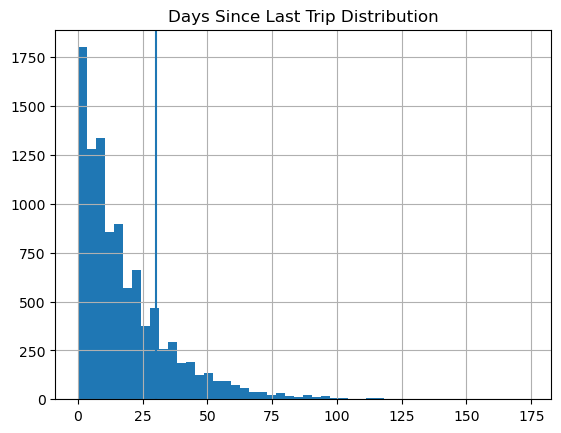

In [68]:
plt.figure()
df["days_since_last_trip"].hist(bins=50)
plt.axvline(CHURN_THRESHOLD_DAYS)
plt.title("Days Since Last Trip Distribution")
plt.show()

### Churn rate Understanding

In [69]:
df["churned"].value_counts(normalize=True) * 100

churned
0    81.14
1    18.86
Name: proportion, dtype: float64

### Outlier Detection

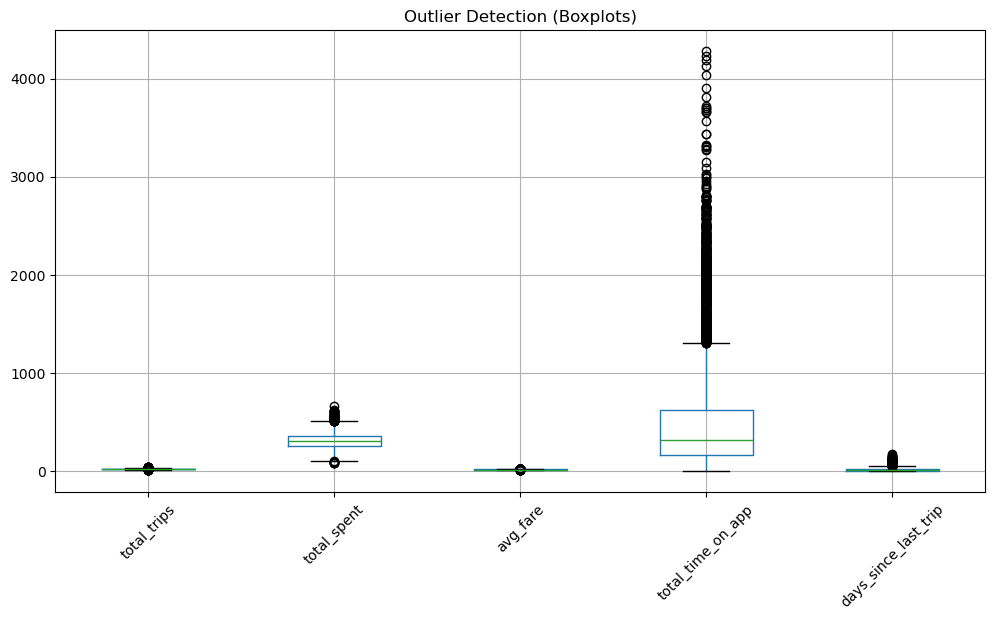

In [70]:
key_outlier_cols = [
    "total_trips",
    "total_spent",
    "avg_fare",
    "total_time_on_app",
    "days_since_last_trip"
]

plt.figure(figsize=(12, 6))
df[key_outlier_cols].boxplot()
plt.xticks(rotation=45)
plt.title("Outlier Detection (Boxplots)")
plt.show()

### Boxplots by churn status

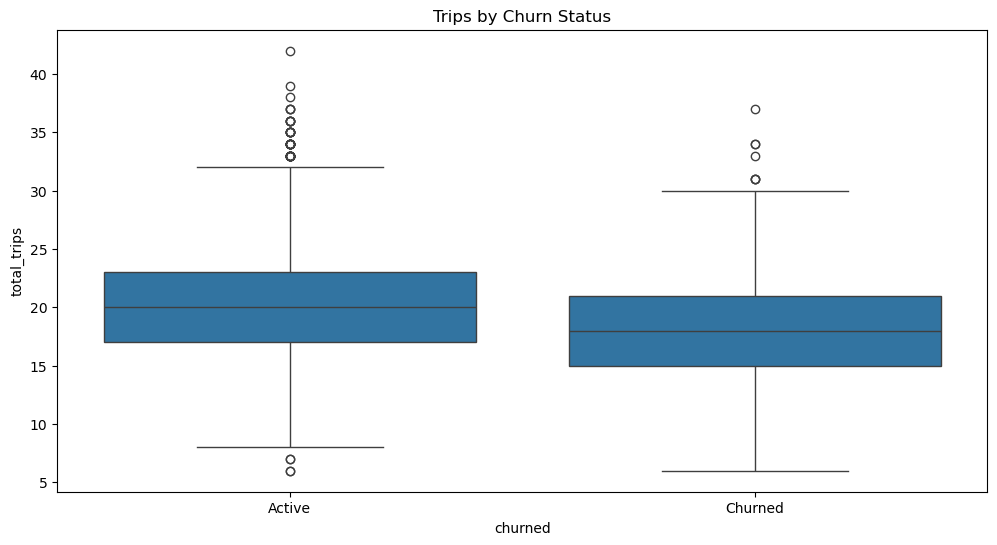

In [71]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="churned",
    y="total_trips",
    data=df
)
plt.title("Trips by Churn Status")
plt.xticks([0, 1], ["Active", "Churned"])
plt.show()

### Churn by city

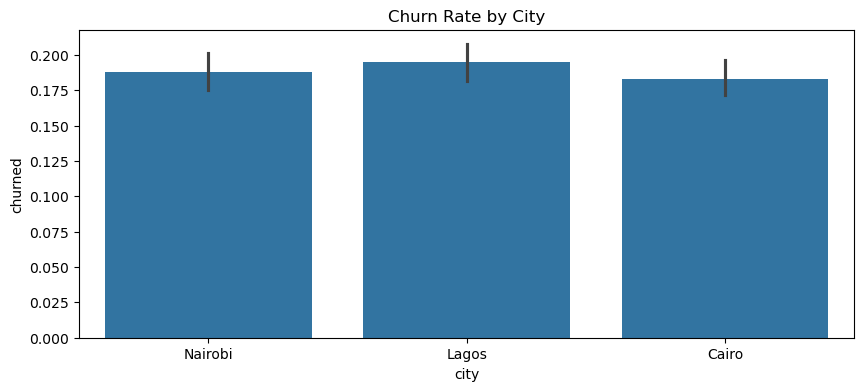

In [72]:
plt.figure(figsize=(10, 4))
sns.barplot(
    x="city",
    y="churned",
    data=df
)
plt.title("Churn Rate by City")
plt.show()

### Churn by loyalty status

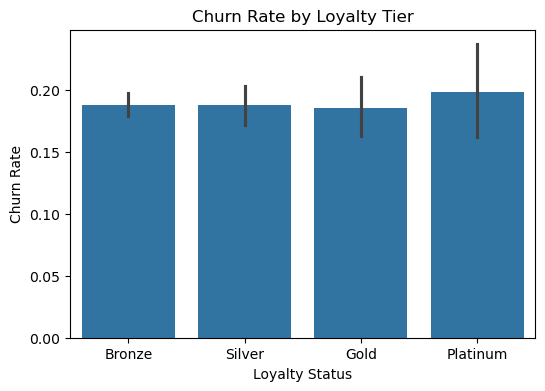

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(
    data=df,
    x="loyalty_status",
    y="churned",
    estimator=lambda x: x.mean()
)
plt.title("Churn Rate by Loyalty Tier")
plt.ylabel("Churn Rate")
plt.xlabel("Loyalty Status")
plt.show()

### Recency distribution

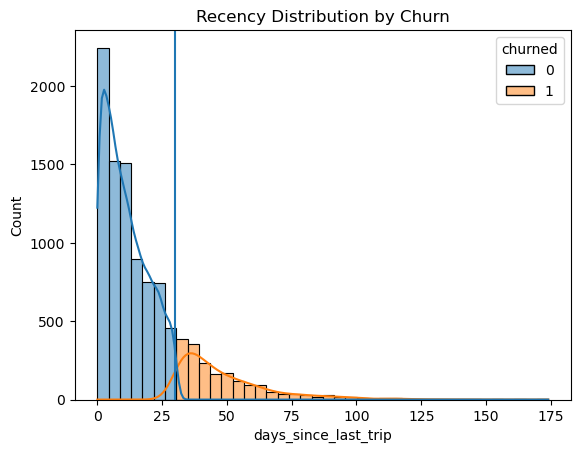

In [74]:
plt.figure()
sns.histplot(
    data=df,
    x="days_since_last_trip",
    hue="churned",
    bins=40,
    kde=True
)
plt.axvline(30)
plt.title("Recency Distribution by Churn")
plt.show()

### Age distribution by churn

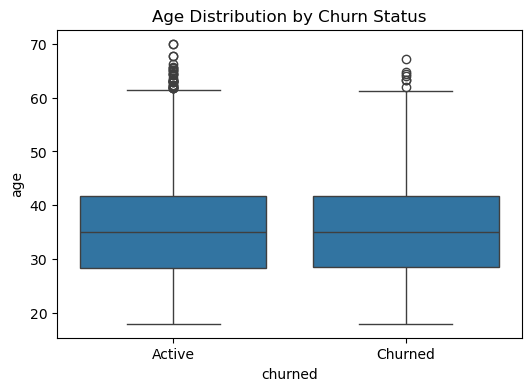

In [75]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x="churned",
    y="age"
)
plt.xticks([0,1], ["Active", "Churned"])
plt.title("Age Distribution by Churn Status")
plt.show()

### Peak & weekend behavior vs churn

In [76]:
df.groupby("churned")[["peak_hour_trip_ratio", "weekend_trip_ratio"]].mean()

,peak_hour_trip_ratio,weekend_trip_ratio
churned,,
0,0.175849,0.290148
1,0.180060,0.282776


### Engagement metrics by churn

In [77]:
df.groupby("churned")[[
    "total_sessions",
    "avg_time_on_app",
    "conversion_rate"
]].mean()

,total_sessions,avg_time_on_app,conversion_rate
churned,,,
0,5.025189,98.476752,0.155952
1,5.081283,96.749389,0.156976


### Conversion rate distribution

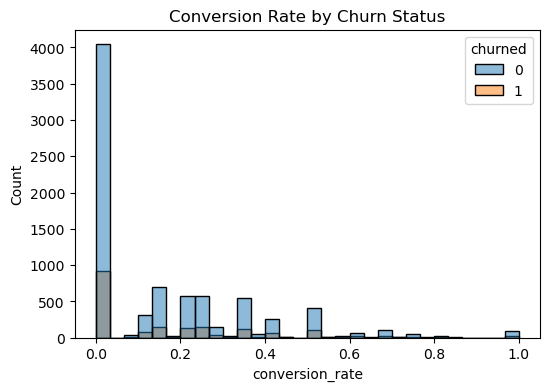

In [78]:
plt.figure(figsize=(6,4))
sns.histplot(
    data=df,
    x="conversion_rate",
    hue="churned",
    bins=30
)
plt.title("Conversion Rate by Churn Status")
plt.show()

### Correlation heatmap (numeric features)

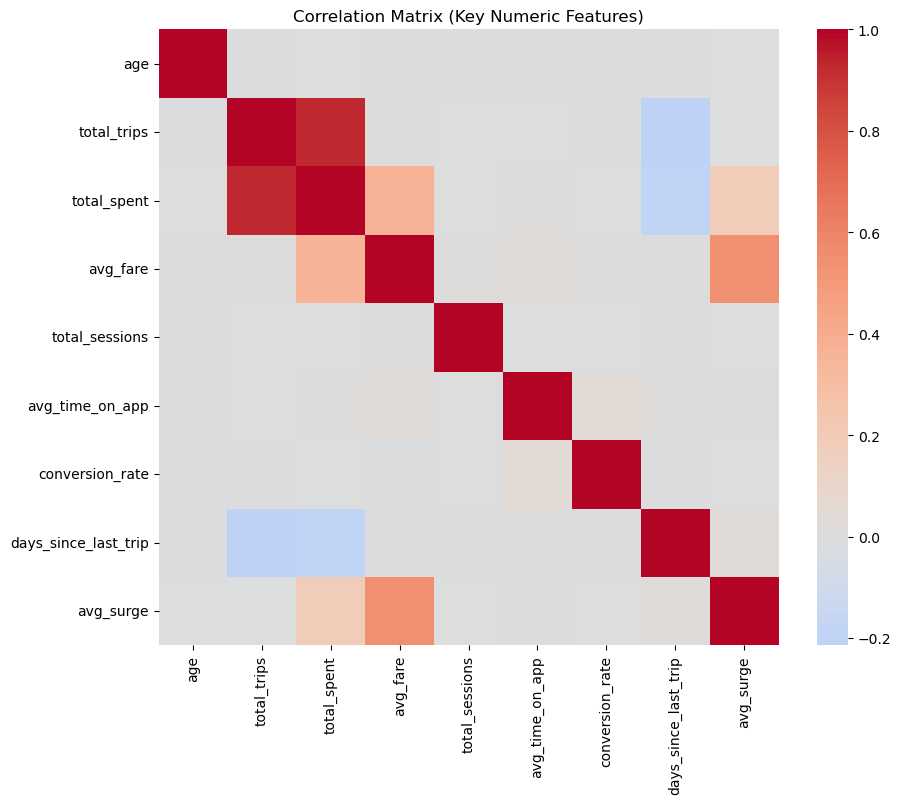

In [79]:
numeric_cols = [
    'age', 'total_trips', 'total_spent', 'avg_fare',
    'total_sessions', 'avg_time_on_app', 'conversion_rate',
    'days_since_last_trip', 'avg_surge'
]

plt.figure(figsize=(10,8))
sns.heatmap(
    df[numeric_cols].corr(),
    cmap="coolwarm",
    center=0,
    annot=False
)
plt.title("Correlation Matrix (Key Numeric Features)")
plt.show()

### Pairplot

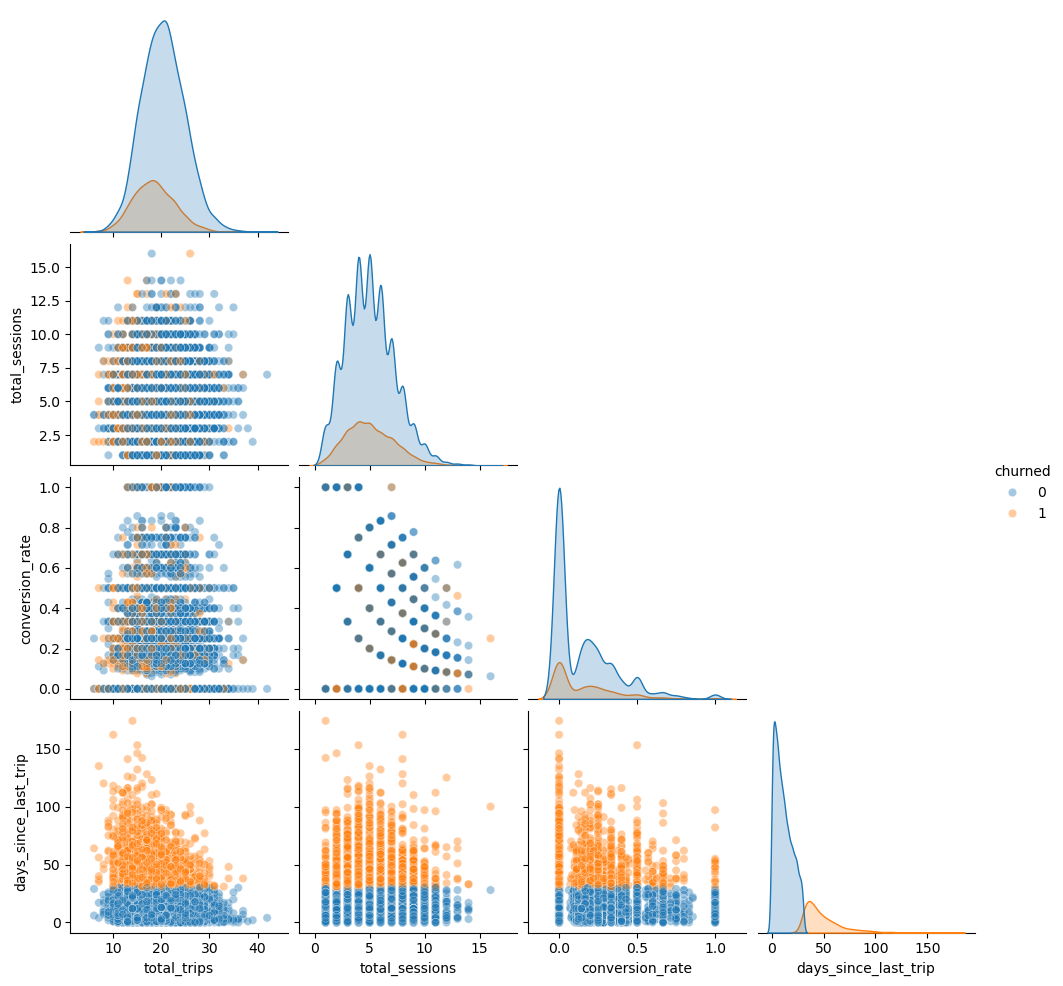

In [80]:
sns.pairplot(
    df,
    vars=[
        "total_trips",
        "total_sessions",
        "conversion_rate",
        "days_since_last_trip"
    ],
    hue="churned",
    corner=True,
    plot_kws={"alpha": 0.4}
)
plt.show()

## Key Insights from EDA

### Who churns
- Churn is higher among low-loyalty tiers
- Certain cities show elevated churn risk
- Non-referred users churn more frequently

### Behavioral signals
- Decline in sessions precedes trip inactivity
- Low conversion rates strongly correlate with churn
- Loss of peak-hour routines is a key warning sign

### Time-based insight
- Most churn occurs after ~30 days of inactivity
- Engagement decay happens before full churn

### Business implications
- Early intervention should focus on declining engagement
- Loyalty and referral programs reduce churn
- City-specific retention strategies may be required


### Saving Dataset

In [81]:
print("Final dataset shape:", df.shape)
print("Unique users:", df["user_id"].nunique())
print("Any duplicated user_id?", df["user_id"].duplicated().any())

df[["churned", "days_since_last_trip"]].describe()

Final dataset shape: (10000, 31)
Unique users: 10000
Any duplicated user_id? False


,churned,days_since_last_trip
count,10000.00000,10000.000000
mean,0.18860,18.169900
std,0.39121,18.363659
min,0.00000,0.000000
25%,0.00000,5.000000
50%,0.00000,12.000000
75%,0.00000,25.000000
max,1.00000,174.000000


### Reorder Columns 

In [82]:
ordered_cols = [
    # Identifiers
    "user_id",
    
    # Target
    "churned",
    "days_since_last_trip",
    
    # Demographics
    "signup_date",
    "age",
    "city",
    "loyalty_status",
    "was_referred",
    
    # Trip behavior
    "total_trips",
    "total_spent",
    "avg_fare",
    "total_tip",
    "avg_tip",
    "avg_surge",
    "weekend_trip_ratio",
    "peak_hour_trip_ratio",
    "first_trip_time",
    "last_trip_time",
    
    # Session engagement
    "total_sessions",
    "total_time_on_app",
    "avg_time_on_app",
    "total_pages_visited",
    "avg_pages_visited",
    "conversion_rate",
    "weekend_session_ratio",
    "peak_hour_session_ratio",
    "first_session_time",
    "last_session_time",
    
    # Legacy / reference columns
    "avg_rating_given",
    "churn_prob",
    "referred_by"
]

# Keep only columns that exist (safe)
ordered_cols = [c for c in ordered_cols if c in df.columns]

df = df[ordered_cols]

### Save the churn-labeled dataset

In [83]:
OUTPUT_PATH = "../data/riders_trips_session_churned.csv"

df.to_csv(OUTPUT_PATH, index=False)

print(f"Churn-labeled dataset saved to: {OUTPUT_PATH}")

Churn-labeled dataset saved to: ../data/riders_trips_session_churned.csv


## RFM Customer Segmentation

RFM (Recency, Frequency, Monetary) segmentation is used to group riders based on
their engagement and value.

This segmentation supports:
- Customer profiling
- Promotion targeting
- Churn risk stratification

RFM scores are derived from behavioral features already present in the dataset.

### Create a clean RFMS working table

In [84]:
rfms = df[[
    "user_id",
    "days_since_last_trip",   # Recency
    "total_trips",            # Frequency
    "total_spent",            # Monetary
    "avg_surge",              # Surge exposure
    "churned"
]].copy()

rfms.head()

,user_id,days_since_last_trip,total_trips,total_spent,avg_surge,churned
0,R00000,25,25,366.05,1.096000,0
1,R00001,5,14,180.53,1.071429,0
2,R00002,14,24,378.99,1.191667,0
3,R00003,61,9,121.47,1.155556,1
4,R00004,12,16,268.43,1.262500,0


### Score each RFMS dimension (quartiles, business-aligned)

In [85]:
# Recency: fewer days = better → reverse labels
rfms["R_score"] = pd.qcut(
    rfms["days_since_last_trip"],
    q=4,
    labels=[4, 3, 2, 1]
)

# Frequency
rfms["F_score"] = pd.qcut(
    rfms["total_trips"].rank(method="first"),
    q=4,
    labels=[1, 2, 3, 4]
)

# Monetary
rfms["M_score"] = pd.qcut(
    rfms["total_spent"].rank(method="first"),
    q=4,
    labels=[1, 2, 3, 4]
)

# Surge exposure (price tolerance)
rfms["S_score"] = pd.qcut(
    rfms["avg_surge"].rank(method="first"),
    q=4,
    labels=[1, 2, 3, 4]
)

### Convert scores to numeric

In [86]:
score_cols = ["R_score", "F_score", "M_score", "S_score"]
rfms[score_cols] = rfms[score_cols].astype(int)

rfms.head()

,user_id,days_since_last_trip,total_trips,total_spent,avg_surge,churned,R_score,F_score,M_score,S_score
0,R00000,25,25,366.05,1.096000,0,2,4,4,1
1,R00001,5,14,180.53,1.071429,0,4,1,1,1
2,R00002,14,24,378.99,1.191667,0,2,4,4,4
3,R00003,61,9,121.47,1.155556,1,1,1,1,3
4,R00004,12,16,268.43,1.262500,0,3,1,2,4


### Compute weighted RFMS score

In [87]:
rfms["RFMS_weighted_score"] = (
    0.30 * rfms["R_score"] +   # Recency
    0.25 * rfms["F_score"] +   # Frequency
    0.25 * rfms["M_score"] +   # Monetary
    0.20 * rfms["S_score"]     # Surge tolerance
)

### Create business segments

In [88]:
rfms["RFMS_segment"] = pd.qcut(
    rfms["RFMS_weighted_score"],
    q=4,
    labels=[
        "At Risk",
        "Occasional Riders",
        "Core Loyal Riders",
        "High-Value Surge-Tolerant"
    ]
)

rfms["RFMS_segment"].value_counts()

RFMS_segment
Occasional Riders            2564
At Risk                      2524
Core Loyal Riders            2478
High-Value Surge-Tolerant    2434
Name: count, dtype: int64

### Validate RFMS against churn

In [89]:
rfms.groupby("RFMS_segment", observed=False)["churned"].mean()

RFMS_segment
At Risk                      0.430666
Occasional Riders            0.180967
Core Loyal Riders            0.135190
High-Value Surge-Tolerant    0.000000
Name: churned, dtype: float64

### Merge RFMS back into main dataset

In [90]:
df = df.merge(
    rfms[["user_id", "RFMS_weighted_score", "RFMS_segment"]],
    on="user_id",
    how="left"
)

In [91]:
df

,user_id,churned,days_since_last_trip,signup_date,age,city,loyalty_status,was_referred,total_trips,total_spent,avg_fare,total_tip,avg_tip,avg_surge,weekend_trip_ratio,peak_hour_trip_ratio,first_trip_time,last_trip_time,total_sessions,total_time_on_app,avg_time_on_app,total_pages_visited,avg_pages_visited,conversion_rate,weekend_session_ratio,peak_hour_session_ratio,first_session_time,last_session_time,avg_rating_given,churn_prob,referred_by,RFMS_weighted_score,RFMS_segment
0,R00000,0,25,2025-01-24,34.729629,Nairobi,Bronze,1,25,366.05,14.642000,4.03,0.161200,1.096000,0.160000,0.160000,2024-05-01 07:21:52+00:00,2025-04-02 14:46:29+00:00,4.0,368.0,92.000000,12.0,3.000000,0.25,1.0,0.000000,2025-04-27 00:49:27,2025-04-27 16:06:46,5.0,0.142431,R00001,2.80,Core Loyal Riders
1,R00001,0,5,2024-09-09,34.571020,Nairobi,Bronze,0,14,180.53,12.895000,0.76,0.054286,1.071429,0.285714,0.071429,2024-05-10 18:14:41+00:00,2025-04-22 04:35:17+00:00,3.0,524.0,174.666667,8.0,2.666667,0.00,1.0,1.000000,2025-04-27 07:10:07,2025-04-27 10:33:25,4.7,0.674161,NaN,1.90,At Risk
2,R00002,0,14,2024-09-07,47.133960,Lagos,Bronze,0,24,378.99,15.791250,5.21,0.217083,1.191667,0.125000,0.166667,2024-06-18 17:48:24+00:00,2025-04-13 00:08:00+00:00,3.0,573.0,191.000000,9.0,3.000000,0.00,1.0,0.666667,2025-04-27 07:32:20,2025-04-27 15:04:35,4.2,0.510379,NaN,3.40,High-Value Surge-Tolerant
3,R00003,1,61,2025-03-17,41.658628,Nairobi,Bronze,0,9,121.47,13.496667,0.87,0.096667,1.155556,0.333333,0.111111,2024-05-15 05:13:12+00:00,2025-02-25 04:22:32+00:00,3.0,226.0,75.333333,5.0,1.666667,0.00,1.0,0.333333,2025-04-26 23:28:16,2025-04-27 09:56:39,4.9,0.244779,NaN,1.40,At Risk
4,R00004,0,12,2024-08-20,40.681709,Lagos,Silver,1,16,268.43,16.776875,9.38,0.586250,1.262500,0.437500,0.187500,2024-05-23 13:02:45+00:00,2025-04-15 05:30:04+00:00,2.0,34.0,17.000000,5.0,2.500000,0.00,1.0,0.000000,2025-04-27 06:25:27,2025-04-27 18:28:35,3.9,0.269960,R00002,2.45,Occasional Riders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,R09995,0,1,2025-04-26,20.688176,Lagos,Silver,0,13,203.15,15.626923,3.22,0.247692,1.146154,0.384615,0.384615,2024-06-07 05:03:58+00:00,2025-04-26 20:07:09+00:00,3.0,175.0,58.333333,11.0,3.666667,0.00,1.0,0.333333,2025-04-27 06:39:23,2025-04-27 18:04:09,4.4,0.028371,NaN,2.30,Occasional Riders
9996,R09996,0,2,2023-07-26,18.000000,Cairo,Silver,0,15,206.71,13.780667,10.64,0.709333,1.033333,0.133333,0.133333,2024-07-30 15:33:18+00:00,2025-04-25 12:34:57+00:00,4.0,159.0,39.750000,11.0,2.750000,0.25,1.0,0.500000,2025-04-27 08:20:45,2025-04-27 15:59:54,4.1,0.290365,NaN,1.90,At Risk
9997,R09997,1,46,2025-04-18,34.197784,Lagos,Bronze,1,18,309.83,17.212778,4.67,0.259444,1.105556,0.333333,0.388889,2024-04-29 07:30:01+00:00,2025-03-12 08:00:59+00:00,5.0,177.0,35.400000,15.0,3.000000,0.20,1.0,0.200000,2025-04-27 04:09:27,2025-04-27 16:00:04,4.7,0.013147,R02155,1.95,Occasional Riders
9998,R09998,0,19,2024-01-10,51.705319,Cairo,Bronze,1,22,342.05,15.547727,10.54,0.479091,1.150000,0.227273,0.045455,2024-05-07 18:37:03+00:00,2025-04-08 14:46:18+00:00,6.0,215.0,35.833333,17.0,2.833333,0.00,1.0,0.000000,2025-04-27 02:05:47,2025-04-27 18:28:25,3.8,0.253959,R07447,2.70,Core Loyal Riders


### Save the FINAL Output

In [92]:
FINAL_OUTPUT_PATH = "../data/riders_trips_session_churned_rfms.csv"

df.to_csv(FINAL_OUTPUT_PATH, index=False)

print(f"Final churn + RFMS dataset saved to: {FINAL_OUTPUT_PATH}")

Final churn + RFMS dataset saved to: ../data/riders_trips_session_churned_rfms.csv


#### Missing values represent customers with no activity in certain channels, which is itself a strong behavioral signal.
#### These are handled systematically during modeling to avoid bias

## RFMS Customer Segmentation Framework

### Overview
RFMS segmentation is an extension of the traditional RFM (Recency, Frequency, Monetary) framework,
adapted specifically for a ride-hailing business context by incorporating **Surge Exposure (S)**.

The goal of RFMS is to segment riders based on:
- **Engagement freshness**
- **Usage habit strength**
- **Revenue contribution**
- **Price tolerance under high-demand conditions**

This segmentation supports:
- Customer profiling
- Promotion and incentive targeting
- Churn risk stratification
- Strategic pricing and loyalty decisions

---

### RFMS Dimensions and Business Meaning

#### Recency (R)
- **Definition:** Days since the rider’s last completed trip
- **Metric used:** `days_since_last_trip`
- **Business meaning:**  
  Measures how recently a rider engaged with the platform.  
  Lower recency indicates stronger engagement and lower churn risk.

---

#### Frequency (F)
- **Definition:** How often a rider uses the service
- **Metric used:** `total_trips`
- **Business meaning:**  
  Captures habit formation.  
  Frequent riders are more likely to remain active and are less sensitive to switching costs.

---

#### Monetary (M)
- **Definition:** Total monetary value contributed by the rider
- **Metric used:** `total_spent`
- **Business meaning:**  
  Reflects direct revenue impact.  
  High-spend riders are strategically important even if they ride less frequently.

---

#### Surge Exposure (S)
- **Definition:** Average surge multiplier experienced by the rider
- **Metric used:** `avg_surge`
- **Business meaning:**  
  Represents **price tolerance under demand pressure**.  
  Riders who continue using the service during surge periods demonstrate higher loyalty
  and lower price sensitivity.

This dimension is particularly important in ride-hailing, where surge pricing is a key
source of both revenue and customer friction.

---

### RFMS Scoring Methodology

Each RFMS component is converted into a **quartile-based score (1–4)**:

- Score **4** → strongest behavior
- Score **1** → weakest behavior

Scoring rules:
- Recency is reverse-scored (lower days = higher score)
- Frequency, Monetary, and Surge are scored normally (higher = better)

This approach ensures:
- Robustness to outliers
- Balanced segment sizes
- Interpretability for stakeholders

---

### Weighted RFMS Score

To reflect real business priorities, RFMS scores are combined into a **weighted composite score**:




#### Rationale for Weights
- **Recency (30%)**: Strongest predictor of churn and disengagement
- **Frequency (25%)**: Indicates habit strength and usage stability
- **Monetary (25%)**: Captures revenue importance
- **Surge Exposure (20%)**: Measures loyalty under price stress

Weights sum to **1.0**, producing a normalized and interpretable loyalty score.

---

### RFMS Segmentation

Based on the weighted RFMS score, riders are segmented into four business-friendly groups:

| Segment | Description |
|------|------------|
| **At Risk / Price Sensitive** | Low engagement, low surge tolerance, highest churn risk |
| **Occasional Riders** | Infrequent usage, moderate value |
| **Core Loyal Riders** | Stable engagement and consistent revenue |
| **High-Value Surge-Tolerant** | Highest value riders with strong price tolerance |

These segments are directly actionable for:
- Targeted promotions
- Retention campaigns
- Loyalty and rewards strategy
- Pricing experiments

---

### Validation
RFMS segments are validated against observed churn behavior.  
Higher-risk segments exhibit significantly higher churn rates, confirming that the
segmentation aligns with real customer behavior and business outcomes.


### EDA on RFMS

### Count of riders per RFMS segment

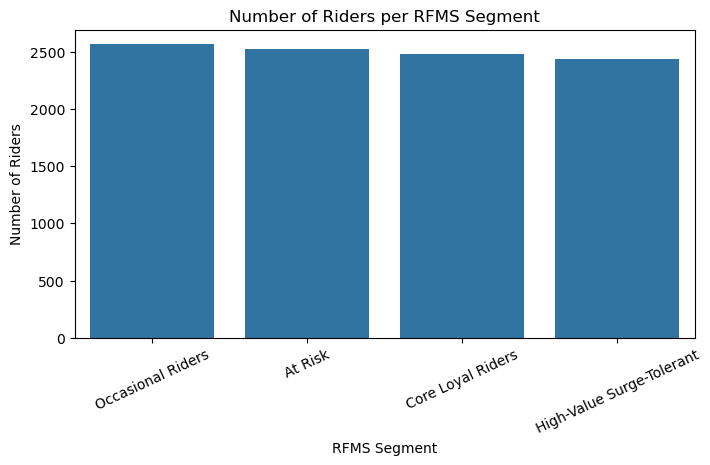

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(
    data=df,
    x="RFMS_segment",
    order=df["RFMS_segment"].value_counts().index
)
plt.title("Number of Riders per RFMS Segment")
plt.xlabel("RFMS Segment")
plt.ylabel("Number of Riders")
plt.xticks(rotation=25)
plt.show()

### Percentage distribution of RFMS segments

In [94]:
segment_pct = (
    df["RFMS_segment"]
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)

segment_pct.columns = ["RFMS_segment", "percentage"]

segment_pct

,RFMS_segment,percentage
0,Occasional Riders,25.64
1,At Risk,25.24
2,Core Loyal Riders,24.78
3,High-Value Surge-Tolerant,24.34


### Distribution of RFMS weighted score

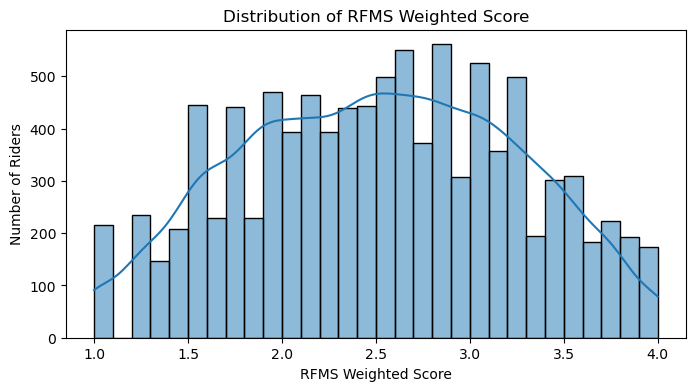

In [95]:
plt.figure(figsize=(8,4))
sns.histplot(
    data=df,
    x="RFMS_weighted_score",
    bins=30,
    kde=True
)
plt.title("Distribution of RFMS Weighted Score")
plt.xlabel("RFMS Weighted Score")
plt.ylabel("Number of Riders")
plt.show()

### Churn rate by RFMS segment

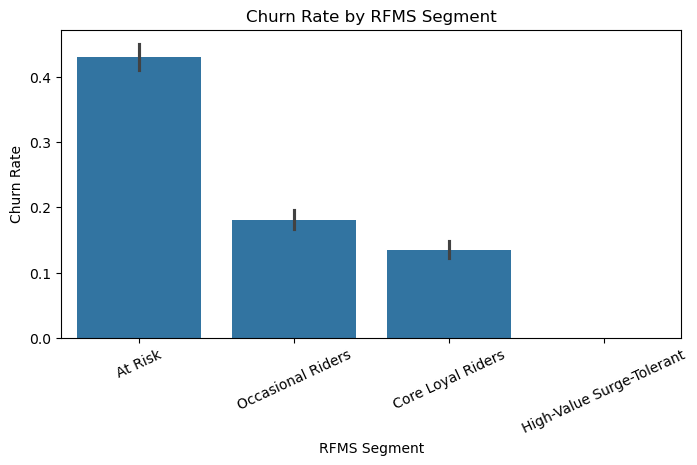

In [97]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=df,
    x="RFMS_segment",
    y="churned"
)
plt.title("Churn Rate by RFMS Segment")
plt.xlabel("RFMS Segment")
plt.ylabel("Churn Rate")
plt.xticks(rotation=25)
plt.show()


### RFMS vs churn vs spend

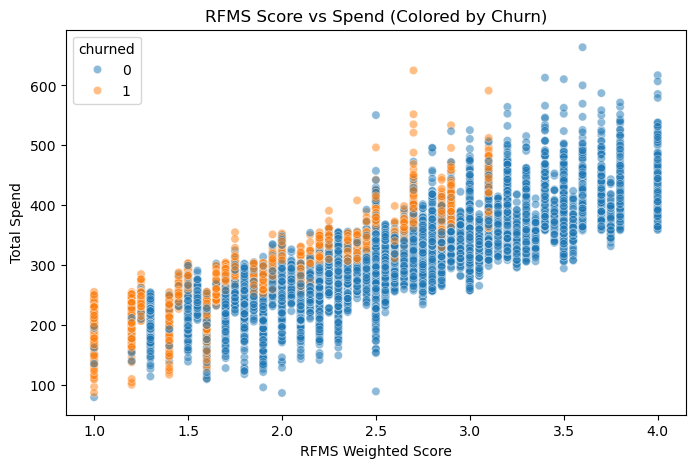

In [100]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df,
    x="RFMS_weighted_score",
    y="total_spent",
    hue="churned",
    alpha=0.5
)
plt.title("RFMS Score vs Spend (Colored by Churn)")
plt.xlabel("RFMS Weighted Score")
plt.ylabel("Total Spend")
plt.show()

### RFMS segment vs surge exposure

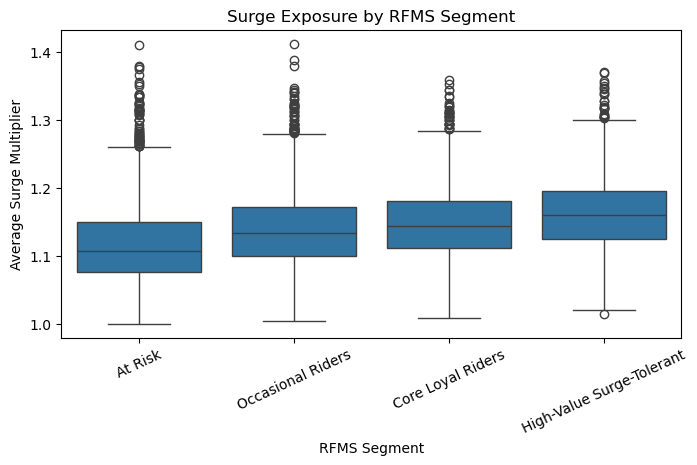

In [101]:
plt.figure(figsize=(8,4))
sns.boxplot(
    data=df,
    x="RFMS_segment",
    y="avg_surge"
)
plt.title("Surge Exposure by RFMS Segment")
plt.xlabel("RFMS Segment")
plt.ylabel("Average Surge Multiplier")
plt.xticks(rotation=25)
plt.show()

## Interpretation of RFMS Segmentation Visuals

### Segment Size & Distribution
The RFMS segmentation produces four well-balanced customer groups, ensuring that
each segment is large enough to support targeted marketing and retention strategies.
This balance confirms the robustness of the quartile-based scoring approach.

### Weighted RFMS Score Distribution
The distribution of the RFMS weighted score shows a smooth spread across riders,
indicating that customer value and loyalty are not concentrated in a small subset
but distributed across the population. This supports the use of RFMS as a continuous
loyalty signal in addition to discrete segments.

### Behavioral Differences
Higher RFMS segments exhibit:
- Higher trip frequency
- Greater total spend
- Higher tolerance to surge pricing
- Stronger engagement and conversion rates

These behavioral patterns support differentiated promotion and retention strategies.

### Business Implications
- **At Risk / Price Sensitive** riders require targeted incentives and off-peak offers
- **Occasional Riders** represent growth opportunities through engagement nudges
- **Core Loyal Riders** benefit from loyalty reinforcement and upsell strategies
- **High-Value Surge-Tolerant** riders should be protected and rewarded rather than discounted

Overall, RFMS segmentation provides a strong, interpretable foundation for
both churn modeling and promotion strategy optimization.

In [103]:
df["churned"] = (df["days_since_last_trip"] > 30).astype(int)

In [104]:
df

,user_id,churned,days_since_last_trip,signup_date,age,city,loyalty_status,was_referred,total_trips,total_spent,avg_fare,total_tip,avg_tip,avg_surge,weekend_trip_ratio,peak_hour_trip_ratio,first_trip_time,last_trip_time,total_sessions,total_time_on_app,avg_time_on_app,total_pages_visited,avg_pages_visited,conversion_rate,weekend_session_ratio,peak_hour_session_ratio,first_session_time,last_session_time,avg_rating_given,churn_prob,referred_by,RFMS_weighted_score,RFMS_segment
0,R00000,0,25,2025-01-24,34.729629,Nairobi,Bronze,1,25,366.05,14.642000,4.03,0.161200,1.096000,0.160000,0.160000,2024-05-01 07:21:52+00:00,2025-04-02 14:46:29+00:00,4.0,368.0,92.000000,12.0,3.000000,0.25,1.0,0.000000,2025-04-27 00:49:27,2025-04-27 16:06:46,5.0,0.142431,R00001,2.80,Core Loyal Riders
1,R00001,0,5,2024-09-09,34.571020,Nairobi,Bronze,0,14,180.53,12.895000,0.76,0.054286,1.071429,0.285714,0.071429,2024-05-10 18:14:41+00:00,2025-04-22 04:35:17+00:00,3.0,524.0,174.666667,8.0,2.666667,0.00,1.0,1.000000,2025-04-27 07:10:07,2025-04-27 10:33:25,4.7,0.674161,NaN,1.90,At Risk
2,R00002,0,14,2024-09-07,47.133960,Lagos,Bronze,0,24,378.99,15.791250,5.21,0.217083,1.191667,0.125000,0.166667,2024-06-18 17:48:24+00:00,2025-04-13 00:08:00+00:00,3.0,573.0,191.000000,9.0,3.000000,0.00,1.0,0.666667,2025-04-27 07:32:20,2025-04-27 15:04:35,4.2,0.510379,NaN,3.40,High-Value Surge-Tolerant
3,R00003,1,61,2025-03-17,41.658628,Nairobi,Bronze,0,9,121.47,13.496667,0.87,0.096667,1.155556,0.333333,0.111111,2024-05-15 05:13:12+00:00,2025-02-25 04:22:32+00:00,3.0,226.0,75.333333,5.0,1.666667,0.00,1.0,0.333333,2025-04-26 23:28:16,2025-04-27 09:56:39,4.9,0.244779,NaN,1.40,At Risk
4,R00004,0,12,2024-08-20,40.681709,Lagos,Silver,1,16,268.43,16.776875,9.38,0.586250,1.262500,0.437500,0.187500,2024-05-23 13:02:45+00:00,2025-04-15 05:30:04+00:00,2.0,34.0,17.000000,5.0,2.500000,0.00,1.0,0.000000,2025-04-27 06:25:27,2025-04-27 18:28:35,3.9,0.269960,R00002,2.45,Occasional Riders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,R09995,0,1,2025-04-26,20.688176,Lagos,Silver,0,13,203.15,15.626923,3.22,0.247692,1.146154,0.384615,0.384615,2024-06-07 05:03:58+00:00,2025-04-26 20:07:09+00:00,3.0,175.0,58.333333,11.0,3.666667,0.00,1.0,0.333333,2025-04-27 06:39:23,2025-04-27 18:04:09,4.4,0.028371,NaN,2.30,Occasional Riders
9996,R09996,0,2,2023-07-26,18.000000,Cairo,Silver,0,15,206.71,13.780667,10.64,0.709333,1.033333,0.133333,0.133333,2024-07-30 15:33:18+00:00,2025-04-25 12:34:57+00:00,4.0,159.0,39.750000,11.0,2.750000,0.25,1.0,0.500000,2025-04-27 08:20:45,2025-04-27 15:59:54,4.1,0.290365,NaN,1.90,At Risk
9997,R09997,1,46,2025-04-18,34.197784,Lagos,Bronze,1,18,309.83,17.212778,4.67,0.259444,1.105556,0.333333,0.388889,2024-04-29 07:30:01+00:00,2025-03-12 08:00:59+00:00,5.0,177.0,35.400000,15.0,3.000000,0.20,1.0,0.200000,2025-04-27 04:09:27,2025-04-27 16:00:04,4.7,0.013147,R02155,1.95,Occasional Riders
9998,R09998,0,19,2024-01-10,51.705319,Cairo,Bronze,1,22,342.05,15.547727,10.54,0.479091,1.150000,0.227273,0.045455,2024-05-07 18:37:03+00:00,2025-04-08 14:46:18+00:00,6.0,215.0,35.833333,17.0,2.833333,0.00,1.0,0.000000,2025-04-27 02:05:47,2025-04-27 18:28:25,3.8,0.253959,R07447,2.70,Core Loyal Riders


In [105]:
df[["days_since_last_trip", "churned"]].corr()
df.groupby("churned")["days_since_last_trip"].describe()

,count,mean,std,min,25%,50%,75%,max
churned,,,,,,,,
0,8114.0,11.066059,8.295811,0.0,4.0,9.0,17.0,30.0
1,1886.0,48.732238,18.461542,31.0,36.0,43.0,56.0,174.0
